In [4]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import ABC, abstractmethod

# Base Classes

In [5]:

class Node:
    '''
    This class represents a node in the tree.
    '''
    pass

class Tree:
    '''
    Base class for RegressionTree and ClassificationTree.
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes.'''
        self.n_min = n_min
    
    def predict(self, x):
        '''Return the prediction for the given 1-D feature vector x.'''
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        Train the tree.

        features: the feature matrix of the training set
        responses: the vector of responses
        D_try: number of features to consider for each split decision
        '''
        N, D = features.shape
        assert responses.shape[0] == N

        if D_try is None:
            D_try = int(np.sqrt(D))
        
        # Initialize the root node
        self.root = Node()
        self.root.features = features
        self.root.responses = responses

        # Build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        Create a split node.

        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                 indices to be considered for the present split

        Returns:
            None, None - if no suitable split has been found, or
            left, right - the children of the split
        '''
        # Check if all responses are equal
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # Compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # Remember the best split so far 
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # Create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # Store children and split condition in the current node
        node.split_index = j_min
        node.threshold = t_min
        node.left = left
        node.right = right

        # Return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        '''Return a 1-D array with D_try randomly selected indices from 0...(D-1).'''
        return np.random.choice(range(D), D_try, replace=False)
        
    def find_thresholds(self, node, j):
        '''Return a 1-D array with all possible thresholds along feature j.'''
        feature_values = node.features[:, j]
        return np.unique(feature_values)
        
    def make_children(self, node, j, t):
        '''Execute the split in feature j at threshold t.

        Return:
            left, right - the children of the split, with features and responses
                          properly assigned according to the split
        '''
        left = Node()
        right = Node()

        # Assign features and responses to the children based on the split condition
        features = node.features
        responses = node.responses
        left_mask = features[:, j] <= t
        right_mask = np.logical_not(left_mask)
        left.features = features[left_mask]
        left.responses = responses[left_mask]
        right.features = features[right_mask]
        right.responses = responses[right_mask]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        '''Turn node into a leaf by computing and setting `node.prediction`.
        
        (Must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        '''Return the resulting loss when the data are split along feature j at threshold t.
        If the split is not admissible, return float('inf').
        
        (Must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [6]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        '''
        Return the loss if we would split the instance along feature j at threshold t
        or float('inf') if there is no feasible split.
        '''
        left_mask = node.features[:, j] <= t
        right_mask = np.logical_not(left_mask)
        
        if np.all(left_mask) or np.all(right_mask):
            # All instances are on one side of the split, not a feasible split
            return float('inf')
        
        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]
        
        left_loss = np.mean((left_responses - np.mean(left_responses))**2)
        right_loss = np.mean((right_responses - np.mean(right_responses))**2)
        
        total_loss = left_loss + right_loss
        
        return total_loss
        
    def make_leaf_node(self, node):
        '''
        Turn the node into a leaf node by computing `node.prediction`.
        '''
        node.prediction = np.mean(node.responses)


# Classification Tree

In [7]:
class ClassificationTree(Tree):
    def __init__(self, classes, n_min=10):
        '''
        Initialize the ClassificationTree.

        classes: a 1-D array with the permitted class labels
        n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        '''
        Return the loss if we would split the instance along feature j at threshold t
        or float('inf') if there is no feasible split.
        '''
        left_mask = node.features[:, j] <= t
        right_mask = np.logical_not(left_mask)
        
        if np.all(left_mask) or np.all(right_mask):
            # All instances are on one side of the split, not a feasible split
            return float('inf')
        
        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]
        
        left_class_counts = np.bincount(left_responses, minlength=len(self.classes))
        right_class_counts = np.bincount(right_responses, minlength=len(self.classes))
        
        left_class_probabilities = left_class_counts / np.sum(left_class_counts)
        right_class_probabilities = right_class_counts / np.sum(right_class_counts)
        
        left_loss = 1.0 - np.max(left_class_probabilities)
        right_loss = 1.0 - np.max(right_class_probabilities)
        
        total_loss = (np.sum(left_class_counts) * left_loss +
                      np.sum(right_class_counts) * right_loss) / len(node.responses)
        
        return total_loss
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        class_counts = np.bincount(node.responses, minlength=len(self.classes))
        dominant_classes = np.where(class_counts == np.max(class_counts))[0]
        node.prediction = np.random.choice(self.classes[np.isin(self.classes, dominant_classes)])


# Evaluation of Regression and Classification Tree

In [8]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [10]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
from sklearn.model_selection import KFold

# Create an instance of RegressionTree
tree = RegressionTree()

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)
fold = 1
accuracies = []

for train_index, test_index in kf.split(features):
    # Split the data into training and testing sets
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = responses[train_index], responses[test_index]

    # Train the RegressionTree on the training data
    tree.train(X_train, y_train)

    # Test the RegressionTree on the testing data
    predictions = [tree.predict(x) for x in X_test]

    # Compute the accuracy of the predictions
    accuracy = np.mean(np.array(predictions) == y_test)
    accuracies.append(accuracy)
    
    # Print the accuracy for the current fold
    print(f"Fold {fold}: Accuracy = {accuracy}")
    fold += 1

# Compute and print the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")


Fold 1: Accuracy = 0.8767123287671232
Fold 2: Accuracy = 0.9315068493150684
Fold 3: Accuracy = 0.9178082191780822
Fold 4: Accuracy = 0.8611111111111112
Fold 5: Accuracy = 0.875
Average Accuracy: 0.8924277016742771


In [11]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
from sklearn.model_selection import StratifiedKFold

# Prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# Get unique class labels
classes = np.unique(labels)

# Perform 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
accuracies = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Train the ClassificationTree on the training data
    tree = ClassificationTree(classes=classes)
    tree.train(X_train, y_train)
    
    # Test the ClassificationTree on the testing data
    predictions = [tree.predict(x) for x in X_test]
    
    # Compute accuracy
    accuracy = np.mean(predictions == y_test)
    accuracies.append(accuracy)
    print(f"Fold {fold}: Accuracy = {accuracy}")
    fold += 1 

# Compute average accuracy across folds
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)



(1797, 64) (1797,)
Fold 1: Accuracy = 0.958904109589041
Fold 2: Accuracy = 0.9452054794520548
Fold 3: Accuracy = 0.9178082191780822
Fold 4: Accuracy = 0.875
Fold 5: Accuracy = 0.9583333333333334
Average Accuracy: 0.9310502283105023


# Regression and Classification Forest

In [12]:
def bootstrap_sampling(features, responses):
    '''
    Return a bootstrap sample of features and responses.

    features: array-like, shape (n_samples, n_features)
        The input features.
    responses: array-like, shape (n_samples,)
        The corresponding responses.

    Returns:
    bootstrap_features: array-like, shape (n_samples, n_features)
        The bootstrap sample of features.
    bootstrap_responses: array-like, shape (n_samples,)
        The corresponding bootstrap sample of responses.
    '''
    n_samples = features.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    bootstrap_features = features[indices]
    bootstrap_responses = responses[indices]
    return bootstrap_features, bootstrap_responses


In [13]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        predictions = [tree.predict(x) for tree in self.trees]
        return np.mean(predictions)


In [14]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for _ in range(n_trees)]
        self.classes = classes

    def train(self, features, responses):
        for tree in self.trees:
            bootstrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(bootstrap_features, bootstrap_responses)

    def predict(self, x):
        predictions = [tree.predict(x) for tree in self.trees]
        class_counts = np.bincount(predictions, minlength=len(self.classes))
        predicted_class = np.argmax(class_counts)
        return self.classes[predicted_class]


# Evaluation of Regression and Decision Forest

In [15]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
from sklearn.model_selection import KFold
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

# Create the RegressionForest with 10 trees
forest = RegressionForest(n_trees=10)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)
fold = 1
for train_index, test_index in kf.split(features):
    print("Fold:", fold)
    fold += 1

    # Split the data into training and testing sets for this fold
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = responses[train_index], responses[test_index]

    # Train the RegressionForest on the training data
    forest.train(X_train, y_train)

    # Test the RegressionForest on the testing data
    predictions = [forest.predict(x) for x in X_test]

    # Evaluate the accuracy of the predictions
    accuracy = np.mean(predictions == y_test)
    print("Accuracy:", accuracy)


(1797, 64) (1797,)
Fold: 1
Accuracy: 0.5205479452054794
Fold: 2
Accuracy: 0.5068493150684932
Fold: 3
Accuracy: 0.5068493150684932
Fold: 4
Accuracy: 0.6527777777777778
Fold: 5
Accuracy: 0.5833333333333334


In [16]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results


# Multi-class Classification Forest

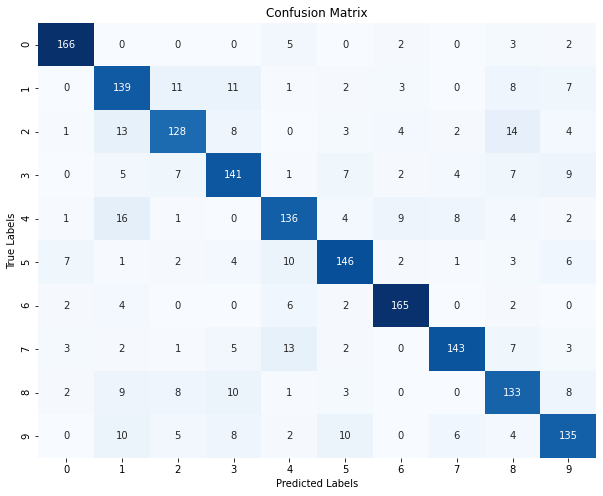

In [17]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix


class ClassificationTree:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        # Build your tree here using the training data
        # You can use any decision tree algorithm or library of your choice
        # For example, you can use scikit-learn's DecisionTreeClassifier
        from sklearn.tree import DecisionTreeClassifier
        self.tree = DecisionTreeClassifier()
        self.tree.fit(X, y)

    def predict(self, X):
        # Implement the prediction logic for your tree here
        return self.tree.predict(X)


class ClassificationForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10):
        self.n_trees = n_trees
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = ClassificationTree()
            # Build each tree using a subset of the training data
            tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)


# Perform 5-fold cross-validation on the entire digits dataset
# Assuming you have X (input features) and y (target labels) already defined

from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Load the digits dataset
digits = load_digits()

# Extract the input features (X) and target labels (y)
X = digits.data
y = digits.target

# Create a ClassificationForest instance
forest = ClassificationForest()

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation and get the predicted labels
predicted_labels = cross_val_predict(forest, X, y, cv=cv)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y, predicted_labels)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.

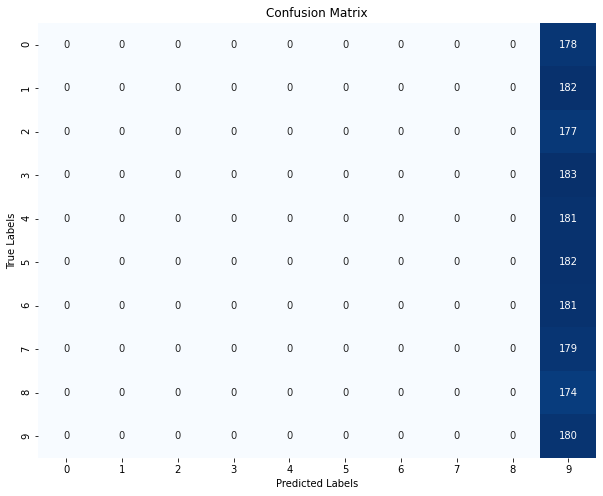

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Load the digits dataset
digits = load_digits()

# Separate the features and labels
X = digits.data
y = digits.target

# Function to perform balanced bootstrap sampling
def balanced_bootstrap_sampling(y, target_class, rest_class):
    target_indices = np.where(y == target_class)[0]
    rest_indices = np.where(y != target_class)[0]
    n_samples = min(len(target_indices), len(rest_indices))
    bootstrap_indices = np.concatenate((np.random.choice(target_indices, n_samples), np.random.choice(rest_indices, n_samples)))
    return bootstrap_indices

# Create an empty confusion matrix
confusion_mat = np.zeros((10, 10))

# Perform 5-fold cross-validation
k = 5
kfolds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for train_index, test_index in kfolds.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a list to store the one-against-the-rest regression forests
    forests = []

    # Train ten one-against-the-rest regression forests
    for target_class in range(10):
        rest_class = [c for c in range(10) if c != target_class]

        # Extend bootstrap_sampling() to balance the dataset
        def extended_bootstrap_sampling(y):
            return balanced_bootstrap_sampling(y, target_class, rest_class)

        # Create a RandomForestRegressor regression forest
        forest = RandomForestRegressor(n_estimators=100, bootstrap=True)

        # Balance the training data by selecting equal samples from target and rest classes
        bootstrap_indices = extended_bootstrap_sampling(y_train)

        # Fit the regression forest on the balanced training data
        forest.fit(X_train[bootstrap_indices], y_train[bootstrap_indices])

        # Append the regression forest to the list
        forests.append(forest)

    # Make predictions using the ensemble of regression forests
    y_pred = np.zeros(len(X_test))
    for i, forest in enumerate(forests):
        y_pred_i = forest.predict(X_test)
        y_pred[y_pred_i >= 0] = i

    # Update the confusion matrix
    confusion_mat += confusion_matrix(y_test, y_pred, labels=list(range(10)))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='.0f', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
